# **Near Field Scan Measurement and Analysis Script**

For 3rd floor system with 1 meter Newmark stage. Compares single- or dual-polarization near field scan of test antenna to that of standard gain horn antenna to obtain directivity, gain, and efficiency estimates.

### Import modules

In [3]:
import sys
sys.path.append('C:/Users/smithlab/Documents/Acquisition-Code/Modules')
import numpy as np
from matplotlib import pyplot as plt
import VNA_control as vc
import stage_control as sc
import probe_deconvolve as pd
import propagation_functions as pf
import scipy.constants
import scipy.io
import time
import datetime
import mainPyDAC2_module as tune

C     = scipy.constants.c
EPS_0 = scipy.constants.epsilon_0 #C^2/(N*m^2)
MU_0  = scipy.constants.mu_0    #m kg s^-2 A^-2
mm = 0.001
cm    = 0.01
GHz   = 1.0E9

### General scan parameters

In [2]:
a_probe = 22.86
b_probe = 10.16

xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm

fstart = 8E9
fstop = 12E9
NumFreqs = 11
NumApMasks = 10
f = np.linspace(fstart, fstop, NumFreqs)
lam_min = C/fstop
dstep = lam_min/2 * 1000 # mm

IFBW = 1000
calfile = 'Aaron_21-11-05'
power = 0 # dBm
sParMeas = 'S12'
speedmms = 25       # don't change this

print('IFBW = {} \nCalibration File = {} \nPower = {} dBm \nMeasuring {}'.format(IFBW, calfile, power, sParMeas))

IFBW = 1000 
Calibration File = Aaron_21-11-05 
Power = 0 dBm 
Measuring S12


### Initialize instruments

In [3]:
## Stage
g = sc.stage_start('169.254.225.173')
sc.stage_home(g,speedmms)

## Arduino
# BAUDRATE, PORTNAME, #DACS
numDACs = 12
tune.setSerial(115200, "COM7", numDACs)
tune.sendInputLen()
msg = tune.receiveFromArduino()

while msg.find("Received: " + str(numDACs) + " from serial.") == -1:
    msg = tune.receiveFromArduino()
    
if not (msg == "NO VAL"):
    print(msg)


## VNA
vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, IFBW, power, 'S12', calfile=calfile)

Received: 12 from serial.
Agilent Technologies,N5222A,MY51421573,A.09.90.10
Initiating VNA...

Done



## **Test antenna**

In [4]:
mat = scipy.io.loadmat('C:/Users/smithlab/Documents/NFS_codes/Mike_Antenna_Tuning/wrc_tuning_states.mat')
ts = mat['ts'].reshape((96, 50))

savename = 'Mike_Antenna'
savepath = 'C:/Users/smithlab/Documents/NFS_codes'

### Scan

#### *Set scan lengths*

In [5]:
Lx_ap = 130
Ly_ap = 120
theta = 30
d = 85

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta))
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta))

xmin = -Lx_scan/2
xmax = Lx_scan/2
ymin = -Ly_scan/2
ymax = Ly_scan/2

x_probe = np.arange(xmin, xmax, dstep)
y_probe = np.arange(ymin, ymax, dstep)
X_probe, Y_probe = np.meshgrid(x_probe, y_probe, indexing='xy')
measurements_x = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in x direction
measurements_y = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in y direction
stops = Y_probe.shape[0] * X_probe.shape[1]

#### *Move to new origin*

In [6]:
center_x = -xrange/2
center_y = -yrange/2
pos_x = -120  # adjust to change x zero position
pos_y = 0  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

(-620.0, -500.0)

#### *Set origin*

In [7]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g)

#### *Start scan - x-polarization*

In [8]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

(-114.0746, -109.0746)

In [ ]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        for jj in range(NumApMasks):
            tune.testProgram12DAC(ts[:,jj])
            time.sleep(0.01)
            measurements_x[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


Est. time remaining: 0.15109775357776217 hours
Est. time remaining: 0.1452602579858568 hours
Est. time remaining: 0.14038622856140137 hours
Est. time remaining: 0.13558275977770487 hours
Est. time remaining: 0.1323429889149136 hours
Est. time remaining: 0.1294886883099874 hours


#### *Start scan - y-polarization*

In [10]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

(-65.0, -60.0)

In [11]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        for jj in range(NumApMasks):
            tune.testProgram12DAC(ts[:,jj])
            time.sleep(0.01)
            measurements_y[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


#### *Concatenate measurements*

In [12]:
measurements = np.stack((measurements_x, measurements_y), axis=4)

### Probe compensation

In [13]:
measurements_corrected = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks, 2), dtype=np.complex128)

for i in range(NumFreqs):

    A_mat = pd.make_A_mat(f[i], a_probe*mm, b_probe*mm, x_probe*mm, y_probe*mm, d*mm)

    for j in range(NumApMasks):

        measurements_corrected[:,:,i,j,:] = np.transpose(pd.probe_deconvolve(np.transpose(measurements[:,:,i,j,:], (1,0,2)), A_mat, x_probe*mm, y_probe*mm), (1,0,2))
    

C:\Users/smithlab/Documents/Aaron/Modules\probe_deconvolve.py:56: RuntimeWarning: invalid value encountered in true_divide
  (np.sin(k*b/2 * np.sin(theta))/((k*b/2)*np.sin(theta))) )


### Propagate

In [25]:
N_theta = 180
N_phi = 180

E_far = np.zeros((N_theta, N_phi, NumFreqs, NumApMasks, 3), dtype=np.complex128)

for i in range(NumFreqs):
    for j in range(NumApMasks):

        Theta_far, Phi_far, E_far[:,:,i,j,:] = pf.propagate_from_scans(measurements_corrected[:,:,i,j,:], f[i], X_probe*mm, Y_probe*mm, N_theta, N_phi)

E_int = np.abs(np.sum(E_far * np.conjugate(E_far), 4)).astype(np.float32)

KeyboardInterrupt: 

### Plot

In [ ]:
f_indx = np.argmin(np.abs(f - 10E9))
m_indx = 0

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(measurements[:,:,0,0,0], extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()

fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int[:,:,f_indx,m_indx]/np.amax(E_int[:,:,f_indx,m_indx])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()


### Save data

In [ ]:
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X_probe,
                                       'Y': Y_probe,
                                       'f': f,
                                       'ts': ts,
                                       'measurements': measurements,
                                       'measurements_corrected': measurements_corrected,
                                       'Theta_far': Theta_far,
                                       'Phi_far': Phi_far,
                                       'E_far': E_far})

## **Standard gain antenna (SGA)**

In [ ]:
savename = 'SGA_X_Band_Horn'
savepath = 'Path/to/data/folder'

### Scan

#### *Set scan lengths*

In [ ]:
Lx_ap = 30
Ly_ap = 40
theta = 60
d = 85

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta))
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta))

xmin = -Lx_scan/2
xmax = Lx_scan/2
ymin = -Ly_scan/2
ymax = Ly_scan/2

x_probe = np.arange(xmin, xmax, dstep)
y_probe = np.arange(ymin, ymax, dstep)
X_probe, Y_probe = np.meshgrid(x_probe, y_probe, indexing='xy')
measurements_x = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs), dtype=np.complex128) # measurements with E field of probe oriented in x direction
measurements_y = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs), dtype=np.complex128) # measurements with E field of probe oriented in y direction
stops = Y_probe.shape[0] * X_probe.shape[1]

#### *Move to new origin*

In [ ]:
center_x = -xrange/2
center_y = -yrange/2
pos_x = 40  # adjust to change x zero position
pos_y = -28  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

#### *Set origin*

In [ ]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g)

#### *Start scan - x-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [ ]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)

        measurements_x[yn,xn,:] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


#### *Start scan - y-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [ ]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        measurements_y[yn,xn,:] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


#### *Concatenate measurements*

In [ ]:
measurements = np.stack((measurements_x, measurements_y), axis=4)

### Probe compensation

In [ ]:
measurements_corrected = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, 2), dtype=np.complex128)

for i in range(NumFreqs):

    A_mat = pd.make_A_mat(f[i], a_probe*mm, b_probe*mm, x_probe*mm, y_probe*mm, d*mm)

    measurements_corrected[:,:,i,:] = np.transpose(pd.probe_deconvolve(np.transpose(measurements[:,:,i,:], (1,0,2)), A_mat, x_probe*mm, y_probe*mm), (1,0,2))
    

### Propagate

In [ ]:
N_theta = 180
N_phi = 180

E_far = np.zeros((N_theta, N_phi, NumFreqs, 3), dtype=np.complex128)

for i in range(NumFreqs):

    Theta_far, Phi_far, E_far[:,:,i,:] = pf.propagate_from_scans(measurements_corrected[:,:,i,:], f[i], X_probe*mm, Y_probe*mm, N_theta, N_phi)

E_int = np.abs(np.sum(E_far * np.conjugate(E_far), 3)).astype(np.float32)

### Plot

In [ ]:
f_indx = np.argmin(np.abs(f - 10E9))

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(measurements[:,:,0,0], extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()

fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int[:,:,f_indx]/np.amax(E_int[:,:,f_indx])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()


### Save data

In [ ]:
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X_probe,
                                       'Y': Y_probe,
                                       'f': f,
                                       'measurements': measurements,
                                       'measurements_corrected': measurements_corrected,
                                       'Theta_far': Theta_far,
                                       'Phi_far': Phi_far,
                                       'E_far': E_far})

## **Calculate beam metrics**

### Load data if not already available

In [5]:
AUT = scipy.io.loadmat('C:/Users/smithlab/Documents/Near_Field_Scans/Mike_Antenna_2022-02-10')
SGA = scipy.io.loadmat('C:/Users/smithlab/Documents/Near_Field_Scans/Mike_Antenna_2022-02-10')

### Calculate gain, directivity, beamwidth, and efficiency

In [39]:
Theta_far = AUT['Theta_far']
Phi_far = AUT['Phi_far']
E_AUT = AUT['E_far']
f = AUT['f']

Lx_ap = 130
Ly_ap = 120

U_int = np.abs(np.sum(E_AUT * np.conjugate(E_AUT), 4)).astype(np.float32)
P_rad = np.trapz(np.trapz(U_int, np.unique(Theta_far), axis=0), np.unique(Phi_far), axis=0)
print(P_rad.shape)

C = 3E8
lam = C/f[0,:]

D_max = 4*np.pi*np.amax(U_int, axis=(0,1))/P_rad
f_indx = np.argmin(np.abs(f - 10E9))
print('Directivity =', 10*np.log10(D_max[f_indx,0]), 'dBi')
D_theoretical = 4*np.pi*(Lx_ap/1000 * Ly_ap/1000)/lam[f_indx]**2
print(10*np.log10(D_theoretical))

(11, 10)
Directivity = 15.40315619081715 dBi
23.38091952937233


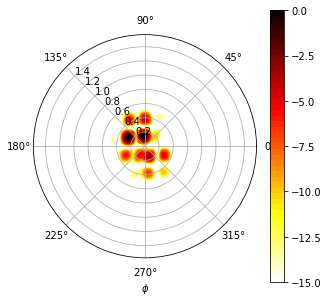

In [16]:
f_indx = np.argmin(np.abs(f - 10E9))
m_indx = 0

# fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
# ax1.imshow(measurements[:,:,0,0,0], extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
# ax1.set_xlabel('x (mm)')
# ax1.set_ylabel('y (mm)')
# plt.show()

fig, ax2 = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5,5))
cs = ax2.contourf(Phi_far, Theta_far, 10*np.log10(E_int[:,:,f_indx,m_indx]/np.amax(E_int[:,:,f_indx,m_indx])), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax2.grid(True)
ax2.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
plt.show()
